In [72]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# XGBoost import (optional)
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except Exception:
    XGBClassifier = None
    xgboost_available = False

# Réglages graphiques
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (9, 6)


In [73]:
"""
Explanation of each line: loading the Wine dataset into a DataFrame

1. wine = load_wine()
---------------------
Loads the Wine dataset from scikit-learn.
This dataset contains chemical measurements of wines from three different cultivars.
The object returned includes both the feature values and the target (class labels).

2. df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
---------------------------------------------------------------
Creates a pandas DataFrame using the numerical data from the dataset.
Each row represents one wine sample.
Each column corresponds to a chemical feature such as alcohol, malic acid, or color intensity.
This makes the dataset easier to manipulate, visualize, and analyze.

3. df['target'] = wine.target
-----------------------------
Adds a new column containing the numeric class label (0, 1, or 2).
This tells us which cultivar each wine belongs to.
It is useful for classification tasks and visualization.

4. df['target_name'] = pd.Categorical.from_codes(wine.target, wine.target_names)
-------------------------------------------------------------------------------
Adds a human-readable version of the target variable.
Instead of numbers (0, 1, 2), this column shows the actual cultivar names.
This makes analysis and plots easier to understand.

5. print('Dataset loaded. Shape:', df.shape)
--------------------------------------------
Displays a confirmation message with the dimensions of the DataFrame.
Shape shows (number of rows, number of columns).
It is a quick check to ensure the dataset was loaded correctly.

Summary:
--------
After these steps, the DataFrame contains all wine features, the numeric target, 
and the categorical target name. It is ready for exploration and modeling.
"""

wine = load_wine()
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['target'] = wine.target
df['target_name'] = pd.Categorical.from_codes(wine.target, wine.target_names)
print('Dataset loaded. Shape:', df.shape)

Dataset loaded. Shape: (178, 15)


In [74]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,target_name
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


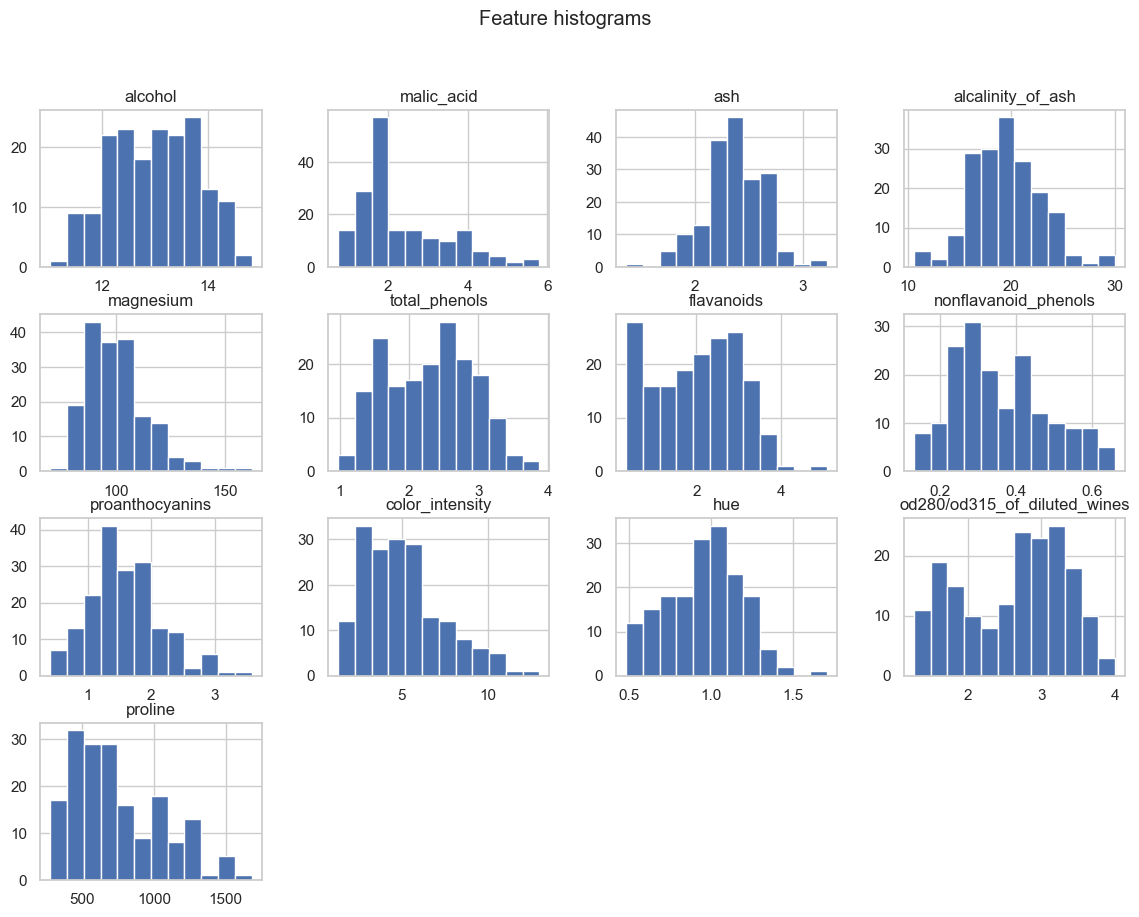

In [75]:
# EDA
df[df.columns[:13]].hist(bins=12, figsize=(14, 10))
plt.suptitle('Feature histograms')
plt.show()


In [76]:
"""
Explanation of preparing X and y for machine learning

1. feature_names = wine.feature_names
-------------------------------------
Retrieves the list of all feature names from the dataset.
Each feature represents a chemical property of the wine (for example alcohol, magnesium, color intensity).
We store this list so we can easily select these columns from the DataFrame.

2. print(f"{feature_names} \n")
------------------------------
Prints the names of the features.
This helps confirm which variables will be used as inputs for the model.

3. X = df[feature_names].values
-------------------------------
Creates the matrix X containing all input features.
- Each row is a wine sample.
- Each column is a feature.
The .values attribute converts the DataFrame into a NumPy array, which is required by most machine learning algorithms.

4. y = df['target'].values
--------------------------
Creates the vector y containing the target values (wine classes).
- y has one element per sample.
- Values are 0, 1, or 2, representing the wine cultivar.
This is the variable the model will try to predict.

5. print(f"{X.shape} \n")
-------------------------
Shows the shape of X.
Format is (number of samples, number of features).
This confirms that X has the correct size.

6. print(f"{y.shape} \n")
-------------------------
Shows the shape of y.
Format is (number of samples,).
This confirms that there is one target value for each sample.

Summary:
--------
X contains all input features used for prediction.
y contains the target class labels.
Both are now ready to be used in a machine learning algorithm such as logistic regression, k-nearest neighbors, or random forest.
"""
# Prepare X and y
feature_names = wine.feature_names
print(f"{feature_names = } \n")

X = df[feature_names].values
y = df['target'].values

print(f"{X.shape = } \n")
print(f"{y.shape = } \n")


feature_names = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'] 

X.shape = (178, 13) 

y.shape = (178,) 



In [77]:
"""
Explanation of the train/test split

1. X_train, X_test, y_train, y_test = train_test_split(...)
----------------------------------------------------------------
We split the dataset into two parts:
- a training set (used to train the model)
- a test set (used to evaluate the model on unseen data)

Parameters used:
- X, y: the full feature matrix and target vector.
- test_size=0.2: 20 percent of the data goes into the test set, 80 percent into training.
- stratify=y: keeps the same proportion of each wine class in both sets.
  This prevents unbalanced splits and makes evaluation more reliable.
- random_state=0: ensures the split is always the same, making results reproducible.

After splitting:
- X_train and y_train contain the samples used for learning.
- X_test and y_test contain the samples used for final evaluation.

2. print('Train samples =', len(y_train), 'Test samples =', len(y_test))
-----------------------------------------------------------------------
Prints the number of samples in each subset.
This is a quick check to confirm the split size and stratification worked correctly.

Summary:
--------
This split ensures the model is trained on most of the data while still being tested fairly on data it has never seen, which helps measure its real performance.
"""
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

print('Train samples =', len(y_train), 'Test samples =', len(y_test))


Train samples = 142 Test samples = 36


In [78]:
"""
Explanation of training and evaluating the Random Forest classifier

1. rf = RandomForestClassifier(n_estimators=200, random_state=0)
---------------------------------------------------------------
Creates a Random Forest model for classification.
Key parameters:
- n_estimators=200: builds an ensemble of 200 decision trees.
  More trees usually mean better performance and more stability.
- random_state=0: ensures reproducible results.

Random Forest works by combining many decision trees and averaging their predictions,
which generally improves accuracy and reduces overfitting.

2. rf.fit(X_train, y_train)
---------------------------
Trains the Random Forest using the training data.
The model learns patterns from the features (X_train) to predict the wine class labels (y_train).

3. y_pred_rf = rf.predict(X_test)
---------------------------------
Uses the trained model to predict the classes of the unseen test samples.
Each prediction corresponds to a wine cultivar.

4. rf_acc = accuracy_score(y_test, y_pred_rf)
---------------------------------------------
Computes the accuracy of the model.
Accuracy is the percentage of correct predictions:
(number of correct predictions) divided by (total number of predictions).

5. print(f"Random Forest accuracy on test set: {rf_acc:.4f}")
--------------------------------------------------------------
Displays the accuracy with four decimal places.
This tells us how well the model performs on new, unseen data.

6. print("Classification report for Random Forest:")
---------------------------------------------------
Prints a header for the classification report.

7. print(classification_report(...))
------------------------------------
Shows detailed metrics for each wine class:
- precision: among predicted samples of a class, how many are correct
- recall: among actual samples of a class, how many were found by the model
- f1-score: harmonic mean of precision and recall
- support: number of samples of each class

target_names=df['target_name'].cat.categories.tolist()
Ensures that the report uses readable class names instead of numeric labels.

Summary:
--------
This code trains a Random Forest classifier, evaluates its accuracy, and prints a full
classification report to understand how well the model performs on each wine class.
"""
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest accuracy on test set: {rf_acc:.4f}")
print("Classification report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=df['target_name'].cat.categories.tolist()))

Random Forest accuracy on test set: 1.0000
Classification report for Random Forest:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



importances = array([0.13417554, 0.02662428, 0.01040879, 0.0258184 , 0.02531265,
       0.05749033, 0.16192898, 0.01180232, 0.01995686, 0.17026461,
       0.06373505, 0.10622448, 0.1862577 ])

indices = array([12,  9,  6,  0, 11, 10,  5,  1,  3,  4,  8,  7,  2])



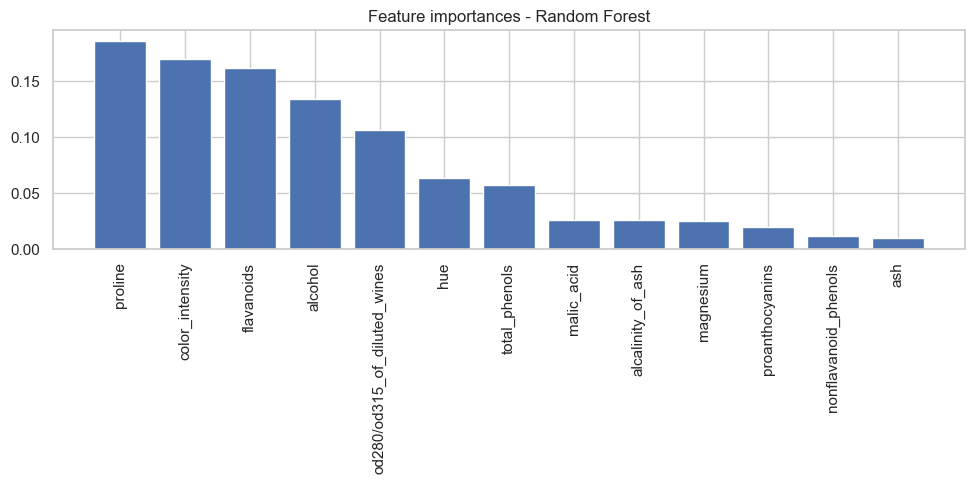

In [79]:
"""
Explanation of plotting feature importances from the Random Forest model

1. importances = rf.feature_importances_
------------------------------------------------
Extracts the importance score of each feature learned by the Random Forest.
Feature importance indicates how useful each feature was for making decisions in the trees.
Higher values mean the feature contributes more to classification.

2. indices = np.argsort(importances)[::-1]
------------------------------------------
Sorts the feature indices in descending order of importance.
np.argsort returns indices sorted in ascending order, so [::-1] reverses the order.
This allows us to plot features from most important to least important.

3. plt.figure(figsize=(10,5))
------------------------------
Creates a new figure with a width of 10 inches and height of 5 inches.
This gives enough space for the labels, especially since they will be rotated.

4. plt.title('Feature importances - Random Forest')
---------------------------------------------------
Adds a title to the plot to describe what is being visualized.

5. plt.bar(range(len(importances)), importances[indices])
---------------------------------------------------------
Creates a bar chart where:
- Each bar represents a feature.
- The height of the bar is the importance score.
- The order follows the sorted indices (most important first).

6. plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
----------------------------------------------------------------------------------------
Sets the labels for the x-axis.
Each tick corresponds to a feature name, reordered by importance.
rotation=90 rotates the labels vertically so they do not overlap and remain readable.

7. plt.tight_layout()
----------------------
Adjusts spacing automatically to prevent labels or titles from being cut off.

8. plt.show()
--------------
Displays the final plot.

Summary:
--------
This visualization shows which features contribute the most to the Random Forest's predictions.
It helps interpret the model by highlighting which chemical properties of wine are most important for distinguishing between wine cultivars.
"""
importances = rf.feature_importances_
print(f"{importances = }\n")
indices = np.argsort(importances)[::-1]
print(f"{indices = }\n")

plt.figure(figsize=(10,5))
plt.title('Feature importances - Random Forest')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [80]:
"""
Compute the confusion matrix for the Random Forest classifier.

This creates a 2D array (matrix) that compares the true class labels
(y_test) with the predicted class labels (y_pred_rf).

Each cell of the matrix shows the number of samples belonging to:
- True Positive
- True Negative
- False Positive
- False Negative

This matrix is useful for evaluating the performance of a classifier,
especially in classification problems with imbalanced classes.

Returns
-------
cm_rf : numpy.ndarray
    The confusion matrix where rows represent actual classes
    and columns represent predicted classes.
"""

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf

array([[12,  0,  0],
       [ 0, 14,  0],
       [ 0,  0, 10]])

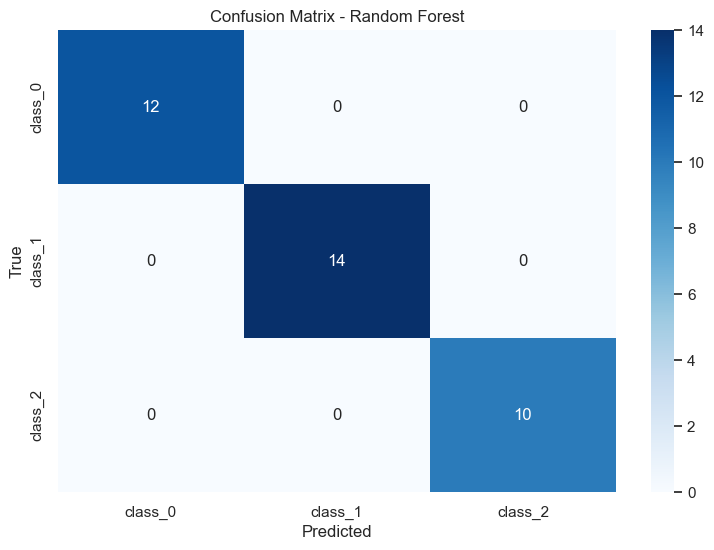

In [81]:

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df['target_name'].cat.categories.tolist(), 
            yticklabels=df['target_name'].cat.categories.tolist())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

XGBoost accuracy on test set: 0.9722
Classification report for XGBoost:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



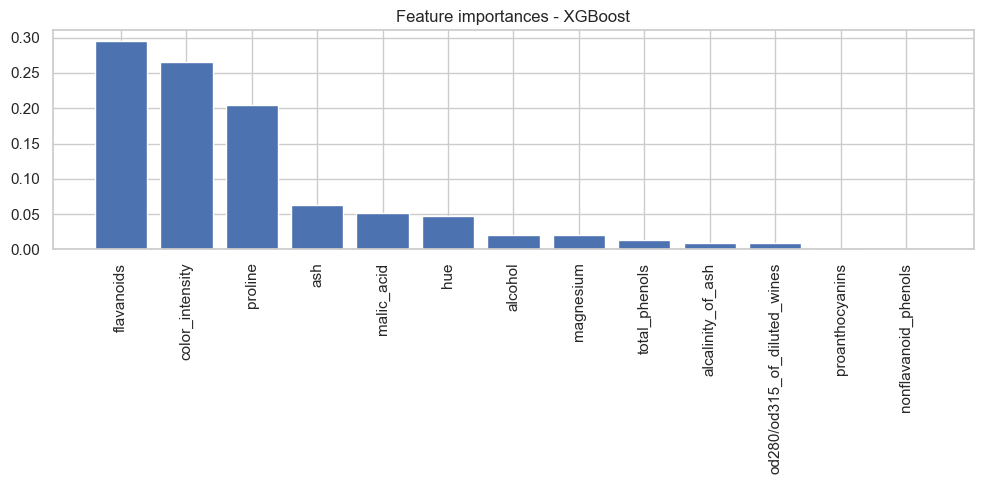

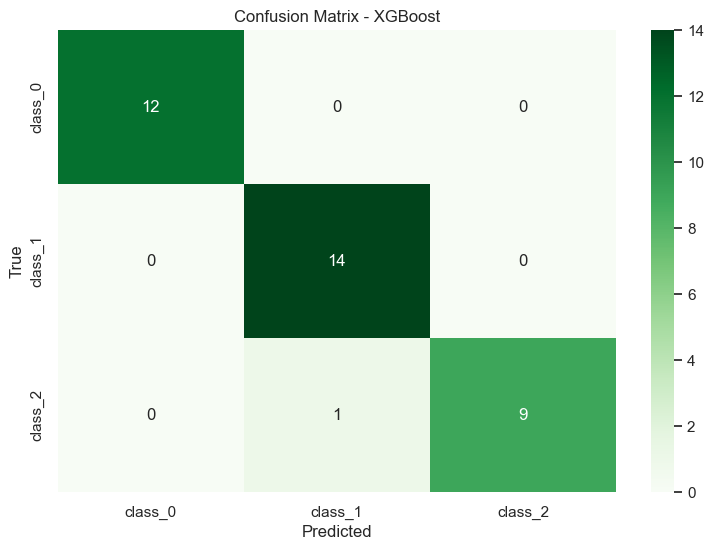

In [82]:
if xgboost_available:
    xgb = XGBClassifier(eval_metric='mlogloss', random_state=0)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    xgb_acc = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost accuracy on test set: {xgb_acc:.4f}")
    print("Classification report for XGBoost:")
    print(classification_report(y_test, y_pred_xgb, target_names=df['target_name'].cat.categories.tolist()))

    # Afficher importances de XGBoost (XGBoost fournit feature_importances_)
    try:
        feat_imp = xgb.feature_importances_
        idx = np.argsort(feat_imp)[::-1]
        plt.figure(figsize=(10,5))
        plt.title('Feature importances - XGBoost')
        plt.bar(range(len(feat_imp)), feat_imp[idx])
        plt.xticks(range(len(feat_imp)), [feature_names[i] for i in idx], rotation=90)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Could not plot XGBoost feature importances:', e)

    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=df['target_name'].cat.categories.tolist(), yticklabels=df['target_name'].cat.categories.tolist())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - XGBoost')
    plt.show()
else:
    print("XGBoost not available. To use XGBoost, install xgboost via 'pip install xgboost'.")


## Columns:
        **precision**:
            Measures the proportion of correct positive predictions for a class.
            Computation:
                true_positives / (true_positives + false_positives)
            Interpretation:
                Among all samples predicted as belonging to the class, precision
                indicates how many were truly from that class.

        **recall**:
            Measures the proportion of actual positives that were correctly identified.
            Computation:
                true_positives / (true_positives + false_negatives)
            Interpretation:
                Among all samples that truly belong to the class, recall shows
                how many the model correctly detected.

        **f1-score**:
            The harmonic mean of precision and recall, providing a balanced metric
            that accounts for both false positives and false negatives.
            Computation:
                2 * (precision * recall) / (precision + recall)
            Interpretation:
                A single score that summarizes model performance on the class.

        **support**:
            The number of true instances of each class in the test dataset.
            Interpretation:
                Indicates how many samples of that class were evaluated.

    Global metrics:
        **accuracy**:
            The proportion of all predictions that were correct across all classes.

        **macro avg**:
            The unweighted average of precision, recall, and f1-score across all classes.
            Each class contributes equally, regardless of how many samples it has.

        **weighted avg**:
            The average of precision, recall, and f1-score weighted by support.
            Classes with more samples have more influence on the final result.

In [ ]:
"""
Create a Random Forest model and compute its learning curve.

A RandomForestClassifier with 200 decision trees is initialized
to study how model performance evolves as the number of training
samples increases.

The learning curve is computed using 5-fold cross-validation and
accuracy as the evaluation metric. It returns three arrays:

- train_sizes : proportions of the training set used
- train_scores : accuracy scores obtained on the training folds
- test_scores : accuracy scores obtained on the validation folds

This analysis helps detect overfitting, underfitting, and whether
adding more data would improve model performance.
"""
rf_for_learning = RandomForestClassifier(n_estimators=200, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    rf_for_learning, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)


In [ ]:
"""
Compute the mean and standard deviation of training and validation scores.

The learning_curve function returns multiple accuracy scores for each
training set size, obtained from cross-validation. To summarize these
results, this block computes:

- train_scores_mean : average training accuracy for each train size
- train_scores_std  : variability of the training accuracy
- test_scores_mean  : average validation accuracy for each train size
- test_scores_std   : variability of the validation accuracy

These statistics are used to plot learning curves and to analyze
model stability, overfitting, or underfitting.
"""
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

Plotting learning curve for Random Forest...


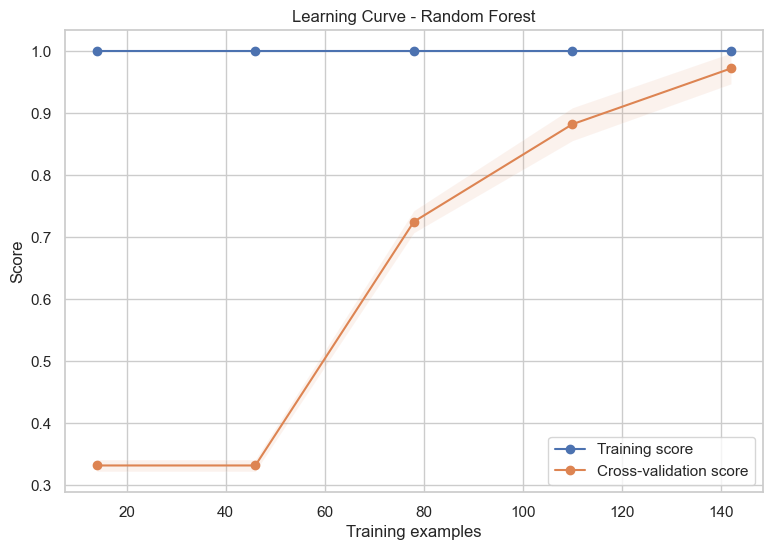

In [83]:
"""
Plot the learning curve for the Random Forest model.

This block creates a figure showing how the model's performance evolves
as the training set size increases. It includes:

- A title and axis labels for clarity.
- A grid to make the plot easier to read.
- Shaded areas (fill_between) representing the standard deviation
  around the mean training and validation scores, showing variability.
- A line plot of the mean training accuracy for each train size.
- A line plot of the mean cross-validation accuracy for each train size.
- A legend identifying each curve.

The resulting plot helps diagnose underfitting, overfitting, and the
amount of data the model needs to generalize well.
"""
print('Plotting learning curve for Random Forest...')
plt.figure()
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
plt.legend(loc='best')
plt.show()
